<a href="https://colab.research.google.com/github/AnirbanMukherjeeXD/tensorflow-vs-keras/blob/master/TF_vs_Keras_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

Using TensorFlow backend.


In [0]:
from keras.utils import to_categorical

##Dataset MNIST

###Tensorflow

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [0]:
batch_size=100
x_batch, y_true_batch = data.train.next_batch(batch_size)

In [7]:
x_batch.shape

(100, 784)

In [0]:
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
x_image = tf.reshape(x, [-1, 28, 28, 1])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

####Conv Layer

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        layer += biases
        return layer, weights

####Pool Layer

In [0]:
def new_pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return layer

####Relu Activation

In [0]:
def new_relu_layer(input, name):    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

####Fully Connected

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer = tf.matmul(input, weights) + biases
        return layer

####CNN:

In [0]:
conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=1, filter_size=5, num_filters=6, name ="conv1")
pool1 = new_pool_layer(conv1, name="pool1")
relu1 = new_relu_layer(pool1, name="relu1")
conv2, weights_conv2 = new_conv_layer(input=relu1, num_input_channels=6, filter_size=5, num_filters=16, name= "conv2")
pool2 = new_pool_layer(conv2, name="pool2")
relu2 = new_relu_layer(pool2, name="relu2")
num_features = relu2.get_shape()[1:4].num_elements()
flat = tf.reshape(relu2, [-1, num_features])
fc1 = new_fc_layer(flat, num_inputs=num_features, num_outputs=128, name="fc1")
relu3 = new_relu_layer(fc1, name="relu3")
fc2 = new_fc_layer(input=relu3, num_inputs=128, num_outputs=10, name="fc2")

In [0]:
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(fc2)
    y_pred_cls = tf.argmax(y_pred, axis=1)

####Cost Function

In [0]:
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

####Optimizer

In [0]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

####Accuracy

In [0]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)

merged_summary = tf.summary.merge_all()

In [0]:
num_epochs = 10
batch_size = 100

####SESSION

In [22]:
num_epochs = 10
batch_size = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        for batch in range(0, int(len(data.train.labels)/batch_size)):
            x_batch, y_true_batch = data.train.next_batch(batch_size)
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            sess.run(optimizer, feed_dict=feed_dict_train)
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(data.train.labels)/batch_size) + batch)
          
        train_accuracy /= int(len(data.train.labels)/batch_size)
        summ, vali_accuracy = sess.run([merged_summary, accuracy], feed_dict={x:data.validation.images, y_true:data.validation.labels})
        writer1.add_summary(summ, epoch)
        end_time = time.time()
        print("Epoch "+str(epoch+1)+"/"+str(num_epochs)+" - "+str(int(end_time-start_time))+"s ",end="")
        print ("  Acc:\t{}".format(train_accuracy),end="")
        print ("  Val acc:\t{}".format(vali_accuracy))


Epoch 1/10 - 9s   Acc:	0.9527636440233751  Val acc:	0.9728000164031982
Epoch 2/10 - 5s   Acc:	0.9857091010700573  Val acc:	0.984000027179718
Epoch 3/10 - 5s   Acc:	0.9895454632152211  Val acc:	0.984000027179718
Epoch 4/10 - 5s   Acc:	0.9910545532269911  Val acc:	0.9850000143051147
Epoch 5/10 - 5s   Acc:	0.9926909159530293  Val acc:	0.98580002784729
Epoch 6/10 - 5s   Acc:	0.9937090966918252  Val acc:	0.9865999817848206
Epoch 7/10 - 5s   Acc:	0.9934909150817177  Val acc:	0.98580002784729
Epoch 8/10 - 5s   Acc:	0.9932909152724526  Val acc:	0.9833999872207642
Epoch 9/10 - 5s   Acc:	0.9948000045256181  Val acc:	0.98580002784729
Epoch 10/10 - 5s   Acc:	0.9945454596389424  Val acc:	0.9819999933242798


###Keras

In [0]:
model = Sequential()

model.add(Conv2D(6, kernel_size=5, activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [0]:
adam=keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 5,142
Trainable params: 5,142
Non-trainable params: 0
____________________________________________________

In [0]:
history=model.fit(data.train.images.reshape(data.train.images.shape[0],28,28,1),data.train.labels,epochs=10,
validation_data=(data.validation.images.reshape(data.validation.images.shape[0],28,28,1),data.validation.labels),
batch_size=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 55000 samples, validate on 5000 samples
Epoch 1/10





55000/55000 [==============================] - 10s 186us/step - loss: 0.1815 - acc: 0.9427 - val_loss: 0.0814 - val_acc: 0.9754
Epoch 2/10
55000/55000 [==============================] - 4s 68us/step - loss: 0.0712 - acc: 0.9781 - val_loss: 0.0658 - val_acc: 0.9816
Epoch 3/10
55000/55000 [==============================] - 4s 69us/step - loss: 0.0576 - acc: 0.9825 - val_loss: 0.0616 - val_acc: 0.9834
Epoch 4/10
55000/55000 [==============================] - 4s 68us/step - loss: 0.0517 - acc: 0.9837 - val_loss: 0.0570 - val_acc: 0.9864
Epoch 5/10
55000/55000 [==============================] - 4s 67us/step - loss: 0.0468 - acc: 0.9857 - val_loss: 0.0631 - val_acc: 0.9840
Epoch 6/10
55000/55000 [==============================] - 4s 68us/step - loss: 0.0488 - acc: 0.9845 - val_loss: 0.0860 - val_acc: 0.9774
Epoch 7/10
55000/55000 [=

#Dataset FMNIST

###Tensorflow

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion/', one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [0]:
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
x_image = tf.reshape(x, [-1, 28, 28, 1])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

####Conv Layer

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        layer += biases
        return layer, weights

####Pool Layer

In [0]:
def new_pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return layer

####Relu Activation

In [0]:
def new_relu_layer(input, name):    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

####Fully Connected

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer = tf.matmul(input, weights) + biases
        return layer

####CNN:

In [0]:
conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=1, filter_size=5, num_filters=6, name ="conv1")
pool1 = new_pool_layer(conv1, name="pool1")
relu1 = new_relu_layer(pool1, name="relu1")
conv2, weights_conv2 = new_conv_layer(input=relu1, num_input_channels=6, filter_size=5, num_filters=16, name= "conv2")
pool2 = new_pool_layer(conv2, name="pool2")
relu2 = new_relu_layer(pool2, name="relu2")
num_features = relu2.get_shape()[1:4].num_elements()
flat = tf.reshape(relu2, [-1, num_features])
fc1 = new_fc_layer(flat, num_inputs=num_features, num_outputs=128, name="fc1")
relu3 = new_relu_layer(fc1, name="relu3")
fc2 = new_fc_layer(input=relu3, num_inputs=128, num_outputs=10, name="fc2")

In [0]:
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(fc2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


####Cost Function

In [0]:
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



####Optimizer

In [0]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

####Accuracy

In [0]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)

merged_summary = tf.summary.merge_all()

In [0]:
num_epochs = 10
batch_size = 100

####SESSION

In [0]:
num_epochs = 10
batch_size = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        for batch in range(0, int(len(data.train.labels)/batch_size)):
            x_batch, y_true_batch = data.train.next_batch(batch_size)
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            sess.run(optimizer, feed_dict=feed_dict_train)
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(data.train.labels)/batch_size) + batch)
          
        train_accuracy /= int(len(data.train.labels)/batch_size)
        summ, vali_accuracy = sess.run([merged_summary, accuracy], feed_dict={x:data.validation.images, y_true:data.validation.labels})
        writer1.add_summary(summ, epoch)
        end_time = time.time()
        print("Epoch "+str(epoch+1)+"/"+str(num_epochs)+" - "+str(int(end_time-start_time))+"s ",end="")
        print ("  Acc:\t{}".format(train_accuracy),end="")
        print ("  Val acc:\t{}".format(vali_accuracy))


Epoch 1/10 - 8s   Acc:	0.9390909160131757  Val acc:	0.9769999980926514
Epoch 2/10 - 5s   Acc:	0.9826909197460522  Val acc:	0.9805999994277954
Epoch 3/10 - 5s   Acc:	0.9864000098271803  Val acc:	0.9811999797821045
Epoch 4/10 - 5s   Acc:	0.9887454640865326  Val acc:	0.9814000129699707
Epoch 5/10 - 5s   Acc:	0.9888363729823719  Val acc:	0.9800000190734863
Epoch 6/10 - 5s   Acc:	0.9891454632715745  Val acc:	0.979200005531311
Epoch 7/10 - 5s   Acc:	0.9915272798321464  Val acc:	0.9807999730110168
Epoch 8/10 - 5s   Acc:	0.9913090981136669  Val acc:	0.9800000190734863
Epoch 9/10 - 5s   Acc:	0.9911636441404169  Val acc:	0.975600004196167
Epoch 10/10 - 5s   Acc:	0.9916363711790604  Val acc:	0.9793999791145325


###Keras

In [0]:
model = Sequential()

model.add(Conv2D(6, kernel_size=5, activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [0]:
adam=keras.optimizers.Adam(lr=0.01)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam, metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 5,142
Trainable params: 5,142
Non-trainable params: 0
__________________________________________________

In [0]:
history=model.fit(data.train.images.reshape(data.train.images.shape[0],28,28,1),data.train.labels,epochs=10,
validation_data=(data.validation.images.reshape(data.validation.images.shape[0],28,28,1),data.validation.labels),
batch_size=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10





55000/55000 [==============================] - 4s 79us/step - loss: 0.1715 - acc: 0.9480 - val_loss: 0.0729 - val_acc: 0.9790
Epoch 2/10
55000/55000 [==============================] - 4s 68us/step - loss: 0.0662 - acc: 0.9800 - val_loss: 0.0620 - val_acc: 0.9816
Epoch 3/10
55000/55000 [==============================] - 4s 68us/step - loss: 0.0562 - acc: 0.9825 - val_loss: 0.0503 - val_acc: 0.9842
Epoch 4/10
55000/55000 [==============================] - 4s 69us/step - loss: 0.0512 - acc: 0.9843 - val_loss: 0.0525 - val_acc: 0.9866
Epoch 5/10
55000/55000 [==============================] - 4s 70us/step - loss: 0.0477 - acc: 0.9852 - val_loss: 0.0507 - val_acc: 0.9866
Epoch 6/10
55000/55000 [==============================] - 4s 70us/step - loss: 0.0445 - acc: 0.9865 - val_loss: 0.0607 - val_acc: 0.9838
Epoch 7/10
55000/55000 [====

#Dataset CIFAR-10

In [0]:
import tensorflow_datasets as tfds
data=tfds.image.cifar.Cifar10

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

###Tensorflow

In [0]:
x = tf.placeholder(tf.float32, shape=[None, 32,32,3], name='X')
x_image = tf.reshape(x, [-1, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

####Conv Layer

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='VALID')
        layer += biases
        return layer, weights

####Pool Layer

In [0]:
def new_pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        return layer

####Relu Activation

In [0]:
def new_relu_layer(input, name):    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

####Fully Connected

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer = tf.matmul(input, weights) + biases
        return layer

####CNN:

In [0]:
conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=3, filter_size=5, num_filters=8, name ="conv1")

relu1 = new_relu_layer(conv1, name="relu1")
pool1 = new_pool_layer(relu1, name="pool1")


conv2, weights_conv2 = new_conv_layer(input=relu1, num_input_channels=8, filter_size=5, num_filters=16, name= "conv2")
relu2 = new_relu_layer(conv2, name="relu2")
pool2 = new_pool_layer(relu2, name="pool2")
num_features = relu2.get_shape()[1:4].num_elements()
flat = tf.reshape(relu2, [-1, num_features])
fc1 = new_fc_layer(flat, num_inputs=num_features, num_outputs=128, name="fc1")
relu3 = new_relu_layer(fc1, name="relu3")
fc2 = new_fc_layer(input=relu3, num_inputs=128, num_outputs=10, name="fc2")

In [0]:
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(fc2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

####Cost Function

In [0]:
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

####Optimizer

In [0]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

####Accuracy

In [0]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)

merged_summary = tf.summary.merge_all()

####SESSION

In [0]:
num_epochs = 20
batch_size = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        for batch in range(0, int(len(x_train)/batch_size)):
            x_batch, y_true_batch = x_train[batch:batch+batch_size],y_train[batch:batch+batch_size]
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            sess.run(optimizer, feed_dict=feed_dict_train)
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(y_train)/batch_size) + batch)
          
        train_accuracy /= int(len(y_train)/batch_size)
        summ, vali_accuracy = sess.run([merged_summary, accuracy], feed_dict={x:x_test, y_true:y_test})
        writer1.add_summary(summ, epoch)
        end_time = time.time()
        print("Epoch "+str(epoch+1)+"/"+str(num_epochs)+" - "+str(int(end_time-start_time))+"s ",end="")
        print ("  Acc:\t{}".format(train_accuracy),end="")
        print ("  Val acc:\t{}".format(vali_accuracy))


Epoch 1/20 - 12s   Acc:	0.9633800122439862  Val acc:	0.23119999468326569
Epoch 2/20 - 11s   Acc:	0.9987200002670288  Val acc:	0.2526000142097473
Epoch 3/20 - 11s   Acc:	1.0  Val acc:	0.27619999647140503
Epoch 4/20 - 11s   Acc:	1.0  Val acc:	0.27790001034736633
Epoch 5/20 - 11s   Acc:	1.0  Val acc:	0.2773999869823456
Epoch 6/20 - 11s   Acc:	1.0  Val acc:	0.2784999907016754
Epoch 7/20 - 11s   Acc:	1.0  Val acc:	0.27869999408721924
Epoch 8/20 - 11s   Acc:	1.0  Val acc:	0.27810001373291016
Epoch 9/20 - 11s   Acc:	1.0  Val acc:	0.2784999907016754
Epoch 10/20 - 11s   Acc:	1.0  Val acc:	0.2791999876499176
Epoch 11/20 - 11s   Acc:	1.0  Val acc:	0.28049999475479126
Epoch 12/20 - 11s   Acc:	1.0  Val acc:	0.28060001134872437
Epoch 13/20 - 11s   Acc:	1.0  Val acc:	0.2808000147342682
Epoch 14/20 - 11s   Acc:	1.0  Val acc:	0.28049999475479126
Epoch 15/20 - 11s   Acc:	1.0  Val acc:	0.28119999170303345
Epoch 16/20 - 11s   Acc:	1.0  Val acc:	0.2816999852657318
Epoch 17/20 - 11s   Acc:	1.0  Val acc:	0.2

##Keras

In [0]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(8, kernel_size=5, activation='relu', input_shape=(32,32,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 8)         608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 16)        3216      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               51328     
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [0]:
history=model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test),batch_size=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 115us/step - loss: 3.2487 - acc: 0.1026 - val_loss: 2.3012 - val_acc: 0.1018
Epoch 2/20
50000/50000 [==============================] - 5s 103us/step - loss: 2.2925 - acc: 0.1138 - val_loss: 2.2690 - val_acc: 0.1453
Epoch 3/20
50000/50000 [==============================] - 5s 102us/step - loss: 1.9558 - acc: 0.2863 - val_loss: 1.7234 - val_acc: 0.3663
Epoch 4/20
50000/50000 [==============================] - 5s 103us/step - loss: 1.6564 - acc: 0.3972 - val_loss: 1.6314 - val_acc: 0.4124
Epoch 5/20
50000/50000 [==============================] - 5s 102us/step - loss: 1.5293 - acc: 0.4455 - val_loss: 1.5179 - val_acc: 0.4521
Epoch 6/20
50000/50000 [==============================] - 5s 102us/step - loss: 1.4454 - acc: 0.4787 - val_loss: 1.4899 - val_acc: 0.4679
Epoch 7/20
50000/50000 [==============================] - 5s 103us/step - loss: 1.3748 - acc: 0.5070 - val_loss: 1.4607 - 

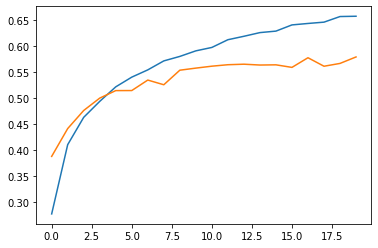

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

#Dataset CIFAR-100

In [0]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [0]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [0]:
y_train.shape

(50000, 100)

###Tensorflow

In [0]:
x = tf.placeholder(tf.float32, shape=[None, 32,32,3], name='X')
x_image = tf.reshape(x, [-1, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 100], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

####Conv Layer

In [0]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='VALID')
        layer += biases
        return layer, weights

####Pool Layer

In [0]:
def new_pool_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        return layer

####Relu Activation

In [0]:
def new_relu_layer(input, name):    
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

####Fully Connected

In [0]:
def new_fc_layer(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer = tf.matmul(input, weights) + biases
        return layer

####CNN:

In [0]:
conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=3, filter_size=5, num_filters=8, name ="conv1")

relu1 = new_relu_layer(conv1, name="relu1")
pool1 = new_pool_layer(relu1, name="pool1")


conv2, weights_conv2 = new_conv_layer(input=relu1, num_input_channels=8, filter_size=5, num_filters=16, name= "conv2")
relu2 = new_relu_layer(conv2, name="relu2")
pool2 = new_pool_layer(relu2, name="pool2")
num_features = relu2.get_shape()[1:4].num_elements()
flat = tf.reshape(relu2, [-1, num_features])
fc1 = new_fc_layer(flat, num_inputs=num_features, num_outputs=128, name="fc1")
relu3 = new_relu_layer(fc1, name="relu3")
fc2 = new_fc_layer(input=relu3, num_inputs=128, num_outputs=100, name="fc2")

In [0]:
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(fc2)
    y_pred_cls = tf.argmax(y_pred, axis=1)

####Cost Function

In [0]:
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



####Optimizer

In [0]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

####Accuracy

In [0]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)

merged_summary = tf.summary.merge_all()

####SESSION

In [0]:
num_epochs = 20
batch_size = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    for epoch in range(num_epochs):
        
        start_time = time.time()
        train_accuracy = 0
        for batch in range(0, int(len(x_train)/batch_size)):
            x_batch, y_true_batch = x_train[batch:batch+batch_size],y_train[batch:batch+batch_size]
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            sess.run(optimizer, feed_dict=feed_dict_train)
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(y_train)/batch_size) + batch)
          
        train_accuracy /= int(len(y_train)/batch_size)
        summ, vali_accuracy = sess.run([merged_summary, accuracy], feed_dict={x:x_test, y_true:y_test})
        writer1.add_summary(summ, epoch)
        end_time = time.time()
        print("Epoch "+str(epoch+1)+"/"+str(num_epochs)+" - "+str(int(end_time-start_time))+"s ",end="")
        print ("  Acc:\t{}".format(train_accuracy),end="")
        print ("  Val acc:\t{}".format(vali_accuracy))


Epoch 1/20 - 11s   Acc:	0.9154399956949055  Val acc:	0.02539999969303608
Epoch 2/20 - 7s   Acc:	0.9902000012546778  Val acc:	0.025699999183416367
Epoch 3/20 - 7s   Acc:	0.9997600001096726  Val acc:	0.026599999517202377
Epoch 4/20 - 7s   Acc:	1.0  Val acc:	0.029200000688433647
Epoch 5/20 - 7s   Acc:	1.0  Val acc:	0.028200000524520874
Epoch 6/20 - 7s   Acc:	1.0  Val acc:	0.028300000354647636
Epoch 7/20 - 7s   Acc:	1.0  Val acc:	0.02889999933540821
Epoch 8/20 - 7s   Acc:	1.0  Val acc:	0.028200000524520874
Epoch 9/20 - 7s   Acc:	1.0  Val acc:	0.029100000858306885
Epoch 10/20 - 7s   Acc:	1.0  Val acc:	0.02850000001490116
Epoch 11/20 - 7s   Acc:	1.0  Val acc:	0.02879999950528145
Epoch 12/20 - 7s   Acc:	1.0  Val acc:	0.02889999933540821
Epoch 13/20 - 7s   Acc:	1.0  Val acc:	0.02889999933540821
Epoch 14/20 - 7s   Acc:	1.0  Val acc:	0.028999999165534973
Epoch 15/20 - 7s   Acc:	1.0  Val acc:	0.02879999950528145
Epoch 16/20 - 7s   Acc:	1.0  Val acc:	0.028699999675154686
Epoch 17/20 - 7s   Acc:	1.

##Keras

In [0]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(8, kernel_size=5, activation='relu', input_shape=(32,32,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
# model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(100, activation='softmax'))

In [0]:
adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 8)         608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
history=model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test),batch_size=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 116us/step - loss: 4.8725 - acc: 0.0233 - val_loss: 4.3877 - val_acc: 0.0438
Epoch 2/20
50000/50000 [==============================] - 5s 107us/step - loss: 4.1411 - acc: 0.0789 - val_loss: 3.9758 - val_acc: 0.1038
Epoch 3/20
50000/50000 [==============================] - 5s 107us/step - loss: 3.7969 - acc: 0.1316 - val_loss: 3.8002 - val_acc: 0.1362
Epoch 4/20
50000/50000 [==============================] - 5s 107us/step - loss: 3.5624 - acc: 0.1698 - val_loss: 3.6866 - val_acc: 0.1586
Epoch 5/20
50000/50000 [==============================] - 5s 108us/step - loss: 3.3767 - acc: 0.2018 - val_loss: 3.6929 - val_acc: 0.1620
Epoch 6/20
50000/50000 [==============================] - 5s 106us/step - loss: 3.2168 - acc: 0.2294 - val_loss: 3.7399 - val_acc: 0.1709
Epoch 7/20
50000/50000 [==============================] - 5s 106us/step - loss: 3.0654 - acc: 0.2572 - val_loss: 3.7750 - 